In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import re
import datetime as dt

In [3]:
smile_on = pd.read_csv('../data/SmileOn11.28.2020.csv', sep = ',', encoding='gbk', skiprows = 2)
data_dict = pd.read_excel('../data/Data_Dictionary.xlsx')
city_info = pd.read_csv('../data2/500_Cities__Local_Data_for_Better_Health__2019_release.csv')

#unused CMS data sets
bill = pd.read_csv('../data2/Medicare_Provider_Utilization_and_Payment_Data__Physician_and_Other_Supplier_PUF_CY2017 (1).csv')
prov_out = pd.read_csv('../data2/Provider_Outpatient_Hospital_Charge_Data_by_APC__CY2017.csv')
apc = pd.read_excel('../data2/2020_October_Web_Addendum_B.10212020.xlsx', skiprows = 2)
hcpcs = pd.read_excel('../data2/2020_October_Web_Addendum_A.10212020.xlsx', skiprows = 1)

## CDC Tooth Loss Data - 500 Cities Project

In [4]:
#Filtering down to TN, measure - all teeth lost among adults >=65 years old, city level data, and age-adjusted prevelance of tooth loss
city_info_tn = city_info[city_info['StateAbbr'] == 'TN']
city_info_tn_teeth_loss = city_info_tn[(city_info_tn['Measure'] == 'All teeth lost among adults aged >=65 Years') & (city_info_tn['GeographicLevel'] == 'City') & (city_info_tn['DataValueTypeID'] == 'AgeAdjPrv')]

In [5]:
#
tooth_loss_chart = city_info_tn_teeth_loss.iloc[:, 0:18].sort_values(by='CityName')
tooth_loss_chart = tooth_loss_chart.sort_values(by='Data_Value', ascending = False)

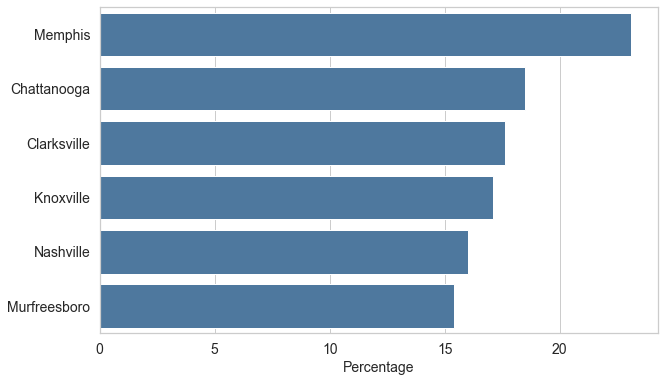

In [6]:
#Chart of major cities in TN - percentage of adults over 65 with all teeth loss
sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=((10, 6)))
sns.barplot(y="CityName", x="Data_Value", data=tooth_loss_chart,
            label="Total", color='#4179AB') #47709D
#ax.set_title('Percentage of Adults > 65 Years Old with Complete Tooth Loss', fontsize = 20)
ax.set_xlabel('Percentage', fontsize = 14, fontfamily = 'Arial')
ax.set_xticklabels([0, 5, 10, 15, 20], fontsize = 14, fontfamily = 'Arial')
ax.set_ylabel('', fontsize=14)
ax.set_yticklabels(tooth_loss_chart['CityName'], fontsize = 14, fontfamily='Arial');

## Smile On Data

In [7]:
smile_on.shape

(40032, 184)

In [8]:
#subset on specific columns
so_1 = smile_on[['CallReportNum', 'ReportVersion', 'CallerNum', 'CityName', 'CountyName', 'PostalCode', 'EnteredOn', 'Birth Year', 'SMILE ON 60+ Screening - Last Screening Date', 'SMILE ON 60+ Oral Care Encounter - What care was provided to the enrollee? (Select all that apply)', 'SMILE ON 60+ Site Information - Enroller ID', 'SMILE ON 60+ Site Information - Enroller Location', 'SMILE ON 60+ Treatment Plan - Is the treatment plan completed?', 'SMILE ON 60+ Treatment Plan - Was a treatment plan developed?', 'SMILE ON 60+ Treatment Plan - Was the enrollee able to be restored to function (can chew) and "social six" esthetics (top front six teeth are present and disease free)', 'SMILE ON 60+ Verification of Eligibility - Transportation Arranged', 'SMILE ON 60+ Verification of Eligibility - Verification of Eligibility']]

In [9]:
so_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40032 entries, 0 to 40031
Data columns (total 17 columns):
 #   Column                                                                                                                                                                   Non-Null Count  Dtype  
---  ------                                                                                                                                                                   --------------  -----  
 0   CallReportNum                                                                                                                                                            40032 non-null  int64  
 1   ReportVersion                                                                                                                                                            40032 non-null  object 
 2   CallerNum                                                                                     

In [10]:
so_1 = so_1.sort_values(by='CallerNum')

In [11]:
#dropped -1 and -2 CallerNums (not unique patients)
so_1 = so_1[(so_1['CallerNum'] != -1) & (so_1['CallerNum'] != -2)]

In [12]:
#rename columns
so_1.columns=['CallReportNum', 'ReportVersion', 'CallerNum', 'CityName', 'CountyName',
       'PostalCode', 'EnteredOn', 'Birth Year',
       'Screening - Last Screening Date',
       'Oral Care Encounter - What care was provided to the enrollee?',
       'Site Information - Enroller ID',
       'Site Information - Enroller Location',
       'Treatment Plan - Is the treatment plan completed?',
       'Treatment Plan - Was a treatment plan developed?',
       'Treatment Plan - Was the enrollee able to be restored to function',
       'Verification of Eligibility Transportation Arranged',
       'Verification of Eligibility']
so_1.columns

Index(['CallReportNum', 'ReportVersion', 'CallerNum', 'CityName', 'CountyName',
       'PostalCode', 'EnteredOn', 'Birth Year',
       'Screening - Last Screening Date',
       'Oral Care Encounter - What care was provided to the enrollee?',
       'Site Information - Enroller ID',
       'Site Information - Enroller Location',
       'Treatment Plan - Is the treatment plan completed?',
       'Treatment Plan - Was a treatment plan developed?',
       'Treatment Plan - Was the enrollee able to be restored to function',
       'Verification of Eligibility Transportation Arranged',
       'Verification of Eligibility'],
      dtype='object')

In [13]:
#focused on patients with responses to treatment plan question
patients_restored = so_1[so_1['Treatment Plan - Was the enrollee able to be restored to function'].isin(['Yes', 'No'])]

In [14]:
#removed duplicate records on CallerNum - kept most recent encounter
patients_restored = patients_restored.sort_values(by = 'EnteredOn')
patients_restored = patients_restored.drop_duplicates(['CallerNum'], keep='last')
patients_restored.shape

(4575, 17)

In [15]:
patients_restored['Treatment Plan - Was the enrollee able to be restored to function'].value_counts()

Yes    2488
No     2087
Name: Treatment Plan - Was the enrollee able to be restored to function, dtype: int64

In [16]:
#subsetted on yes and no
patients_restored_yes = patients_restored[patients_restored['Treatment Plan - Was the enrollee able to be restored to function'] == 'Yes']
patients_restored_no = patients_restored[patients_restored['Treatment Plan - Was the enrollee able to be restored to function'] == 'No']

In [17]:
#created new data frames
yes = patients_restored_yes['Site Information - Enroller ID'].value_counts().to_frame().reset_index()
no = patients_restored_no['Site Information - Enroller ID'].value_counts().to_frame().reset_index()

In [18]:
#merged the data frames
combo = pd.merge(yes, no, on = 'index')

In [19]:
#created a 'total' column - added yeses and nos
combo['total'] = combo['Site Information - Enroller ID_x'] + combo['Site Information - Enroller ID_y']

In [20]:
#created a percentage column - yes/total
combo['percentage'] = (combo['Site Information - Enroller ID_x']/combo['total'])*100

In [21]:
#renamed columns
combo.columns = ['location', 'restored_yes', 'restored_no', 'total', 'percentage' ]

In [22]:
#saved just the first five rows to combo
combo = combo.head()

<BarContainer object of 5 artists>

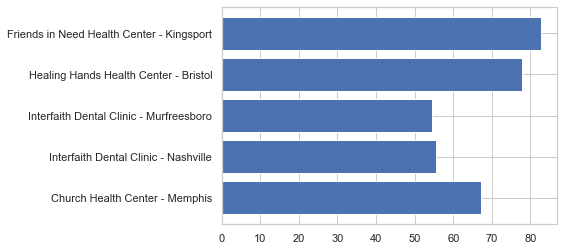

In [23]:
#created bar chart of percentages of clinics with most yeses. Decided the percentages are misleading
plt.barh('location', 'percentage', data = combo)

In [24]:
#decided we wanted clinic labels to text wrapped
print(re.sub(' - ', '\n', 'Church Health Center - Memphis'))

Church Health Center
Memphis


In [25]:
#iterated above code through data frame
list = []
for index, row in combo.iterrows():
    list.append(re.sub(' - ', '\n', row['location']))

In [26]:
list

['Church Health Center\nMemphis',
 'Interfaith Dental Clinic\nNashville',
 'Interfaith Dental Clinic\nMurfreesboro',
 'Healing Hands Health Center\nBristol',
 'Friends in Need Health Center\nKingsport']

In [27]:
#created new location column in comba data frame
combo['new'] = list

In [28]:
#sorted data frame so it plotted correctly on chart
combo = combo.sort_values(by = 'restored_yes')

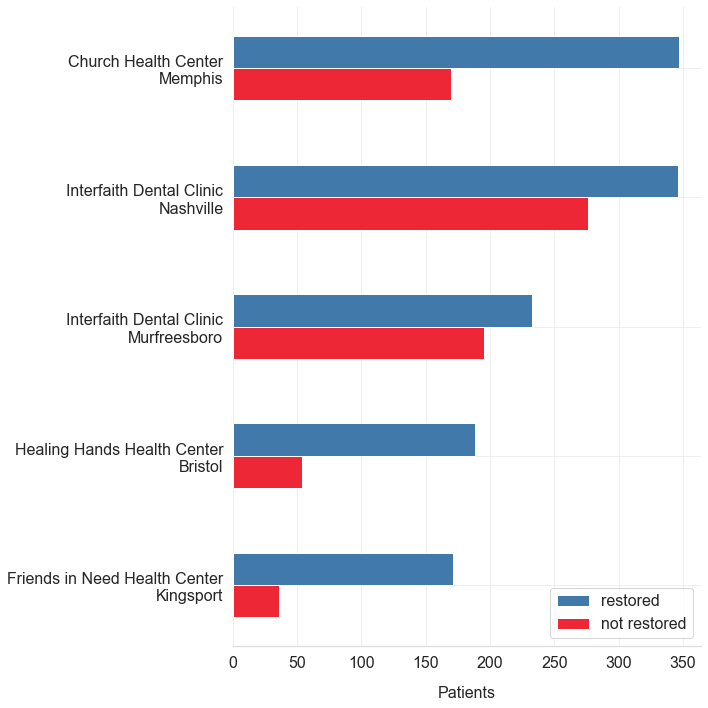

In [29]:
# Create a grouped bar chart, with location as the y-axis
# and number of patients as the variable we're grouping on so there
# are two bars per location.
fig, ax = plt.subplots(figsize=((10, 10)))

# Our y-axis. We basically just want a list
# of numbers from zero with a value for each
# of our locations.
y = np.arange(len(combo['new'].unique()))

# Define bar width. We need this to offset the second bar.
width = 0.25

b1 = ax.barh(y, combo['restored_no'],
            width, label='not restored', color='#EE2737')
# Same thing, but offset the y.
b2 = ax.barh(y + width, combo['restored_yes'],
            width, label='restored', color = '#4179AB')


# Fix the y-axes.
ax.set_yticks(y + width / 2)
ax.set_yticklabels(combo['new'].unique())
plt.yticks(fontsize = 16)

# Add legend.

#change order of items in legend
handles, labels = plt.gca().get_legend_handles_labels()
order = [1,0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize = 16)

# Axis styling.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(True, color='#EEEEEE')

# Add axis and chart labels.
#ax.set_xlabel('Location', labelpad=15, fontsize=12)
ax.set_xlabel('Patients', labelpad=15, fontsize=16, fontfamily = 'Arial')
plt.xticks(fontsize=16)
#ax.set_title('Clinic Locations with the Most Restored Patients', pad=15)

fig.tight_layout()

## Unique patients

In [30]:
patients = so_1.drop_duplicates(['CallerNum'], keep='first')

In [31]:
patients.shape

(8706, 17)

In [32]:
#find number of patients in each city
patients_city = patients.groupby('CityName').size()

In [33]:
#make new data frame
patients_city = patients_city.to_frame().reset_index()

In [34]:
#filter to major cities in tooth loss data set
patients_city = patients_city[patients_city.CityName.isin(['Murfreesboro', 'Nashville', 'Chattanooga', 'Knoxville', 'Clarksville', 'Memphis'])]

In [35]:
#rename columns
patients_city.columns = ['City', 'Smile On Patients']

In [36]:
#tried to get text to center align
patients_city = patients_city.sort_values(by = 'Smile On Patients', ascending = False)
patients_city.style.set_properties(**{'text-align': 'center', 'colheader_justify': 'center'})

,City,Smile On Patients
239,Memphis,1424
263,Nashville,1142
262,Murfreesboro,406
195,Knoxville,386
69,Clarksville,120
63,Chattanooga,18


In [37]:
patients_city

,City,Smile On Patients
239,Memphis,1424
263,Nashville,1142
262,Murfreesboro,406
195,Knoxville,386
69,Clarksville,120
63,Chattanooga,18


## Smile On Demographic Info

In [38]:
#new subset on specific columns
so_2 = smile_on[['ReportVersion', 'CallerNum', 'CityName', 'CountyName', 'PostalCode', 'EnteredOn', 'Birth Year', 'SMILE ON 60+ Demographic Information - Gender', 'SMILE ON 60+ Demographic Information - Preferred Language/Language Needed', 'SMILE ON 60+ Demographic Information - Race/Ethnicity', 'SMILE ON 60+ Demographic Information - # of People in Household', 'SMILE ON 60+ Screening - Last Screening Date', 'SMILE ON 60+ Oral Care Encounter - What care was provided to the enrollee? (Select all that apply)', 'SMILE ON 60+ Site Information - Enroller ID', 'SMILE ON 60+ Site Information - Enroller Location']]

In [39]:
#removed -1 and -2 CallerNums and dropped duplicate CallerNums, keeping last encounter
so_2 = so_2[(so_2['CallerNum'] != -1) & (so_2['CallerNum'] != -2)]
so_2 = so_2.sort_values(by='CallerNum')
patients_demo = so_2.drop_duplicates(['CallerNum'], keep='last')

In [40]:
patients_demo.shape

(8706, 15)

In [41]:
patients_demo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8706 entries, 937 to 0
Data columns (total 15 columns):
 #   Column                                                                                              Non-Null Count  Dtype  
---  ------                                                                                              --------------  -----  
 0   ReportVersion                                                                                       8706 non-null   object 
 1   CallerNum                                                                                           8706 non-null   int64  
 2   CityName                                                                                            8527 non-null   object 
 3   CountyName                                                                                          8593 non-null   object 
 4   PostalCode                                                                                          8022 non-null  

In [42]:
patients_demo['SMILE ON 60+ Demographic Information - Gender'].value_counts()

Female         5611
Male           2991
Transgender       1
Other             1
Name: SMILE ON 60+ Demographic Information - Gender, dtype: int64

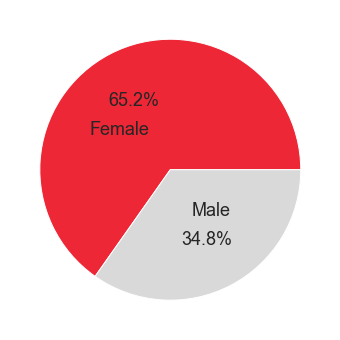

In [43]:
#gender pie chart
x = [5611, 2991]
y = ['Female', 'Male']
color_list = ['#EE2737', '#D9D9D9'] #4179AB

fg, ax = plt.subplots(figsize=(6,6))
autotexts = ax.pie(x, labels = y, autopct = '%1.1f%%', colors = color_list, labeldistance = .35, textprops=dict(fontsize=18, fontfamily='Arial'))
#plt.setp(autotexts, size=8)
plt.show()

In [44]:
#race breakdown data frame
race_ethnicity = patients_demo['SMILE ON 60+ Demographic Information - Race/Ethnicity'].value_counts().to_frame().reset_index()

In [45]:
#rename columns
race_ethnicity.columns = ['Race/Ethnicity', 'Enrollees']

In [46]:
#sort values so they show up the right way on the chart
race_ethnicity = race_ethnicity.sort_values(by='Enrollees')
race_ethnicity

,Race/Ethnicity,Enrollees
7,Pacific Islander,4
6,Multi-racial,27
5,American Indian and Alaska Native,46
4,Unknown,97
3,Asian,119
2,Hispanic,350
1,African American,2229
0,Caucasian,4950


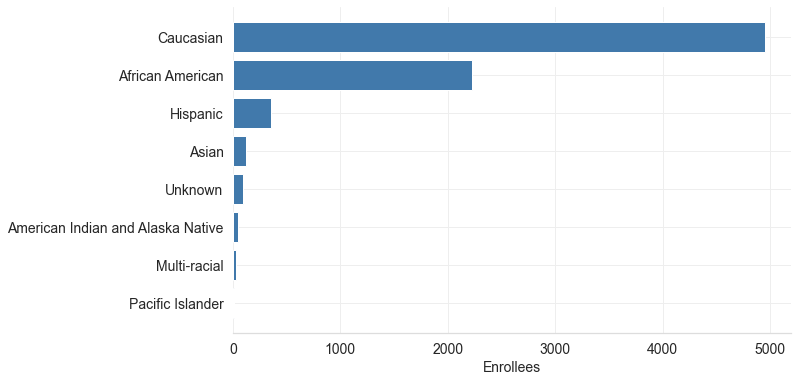

In [47]:
#race/ethnicity breakdown bar chart
f, ax = plt.subplots(figsize=((10,6)))
ax.barh("Race/Ethnicity", "Enrollees", data=race_ethnicity, label="Total", color='#4179AB') #47709D

#labels
ax.set_xlabel('Enrollees', fontsize = 14, fontfamily = 'Arial')
ax.set_xticklabels([0, 1000, 2000, 3000, 4000, 5000], fontsize = 14, fontfamily = 'Arial')
ax.set_ylabel('', fontsize=14)
ax.set_yticklabels(race_ethnicity['Race/Ethnicity'], fontsize = 14, fontfamily='Arial')

#styling
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(True, color='#EEEEEE');

In [48]:
#convert Birth Year column to numeric
patients_demo.loc[:,'Birth Year'] = pd.to_numeric(patients_demo.loc[:,'Birth Year'].fillna('2020'),  errors='coerce')

C:\Users\heath\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [49]:
patients_demo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8706 entries, 937 to 0
Data columns (total 15 columns):
 #   Column                                                                                              Non-Null Count  Dtype  
---  ------                                                                                              --------------  -----  
 0   ReportVersion                                                                                       8706 non-null   object 
 1   CallerNum                                                                                           8706 non-null   int64  
 2   CityName                                                                                            8527 non-null   object 
 3   CountyName                                                                                          8593 non-null   object 
 4   PostalCode                                                                                          8022 non-null  

In [50]:
#find age of patients
age = []
for ind, row in patients_demo.iterrows():
    age.append(2020.0 - row['Birth Year'])

In [51]:
age

[120.0,
 -2650.0,
 76.0,
 66.0,
 78.0,
 69.0,
 83.0,
 68.0,
 66.0,
 75.0,
 69.0,
 81.0,
 63.0,
 62.0,
 75.0,
 72.0,
 81.0,
 74.0,
 80.0,
 69.0,
 77.0,
 63.0,
 73.0,
 76.0,
 76.0,
 80.0,
 66.0,
 68.0,
 69.0,
 66.0,
 75.0,
 86.0,
 63.0,
 64.0,
 92.0,
 67.0,
 62.0,
 64.0,
 73.0,
 64.0,
 76.0,
 67.0,
 65.0,
 66.0,
 67.0,
 67.0,
 65.0,
 120.0,
 76.0,
 75.0,
 75.0,
 73.0,
 63.0,
 72.0,
 64.0,
 69.0,
 63.0,
 93.0,
 67.0,
 74.0,
 67.0,
 70.0,
 62.0,
 69.0,
 64.0,
 68.0,
 71.0,
 68.0,
 69.0,
 79.0,
 75.0,
 65.0,
 74.0,
 78.0,
 76.0,
 71.0,
 64.0,
 62.0,
 72.0,
 70.0,
 63.0,
 67.0,
 75.0,
 74.0,
 71.0,
 66.0,
 79.0,
 66.0,
 84.0,
 67.0,
 71.0,
 64.0,
 66.0,
 75.0,
 69.0,
 64.0,
 98.0,
 78.0,
 63.0,
 68.0,
 68.0,
 67.0,
 73.0,
 82.0,
 70.0,
 84.0,
 66.0,
 64.0,
 73.0,
 84.0,
 64.0,
 80.0,
 64.0,
 77.0,
 83.0,
 68.0,
 66.0,
 71.0,
 72.0,
 67.0,
 70.0,
 69.0,
 79.0,
 72.0,
 71.0,
 75.0,
 66.0,
 66.0,
 71.0,
 67.0,
 67.0,
 73.0,
 70.0,
 76.0,
 63.0,
 73.0,
 68.0,
 67.0,
 69.0,
 63.0,
 65.0,
 66.0,
 

In [52]:
len(age)

8706

In [53]:
#created new column in data frame
patients_demo['age'] = age

<ipython-input-53-7a45f0f5cddd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patients_demo['age'] = age


In [55]:
#patients_demo

In [56]:
#convert age column from float to integer
patients_demo['age'] = patients_demo.age.dropna().astype(int)

<ipython-input-56-5460b90e8250>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patients_demo['age'] = patients_demo.age.dropna().astype(int)


In [57]:
#eligible paticipants/filter out 120 year old
age_chart = patients_demo[(patients_demo['age'] > 59) & (patients_demo['age'] < 111)]

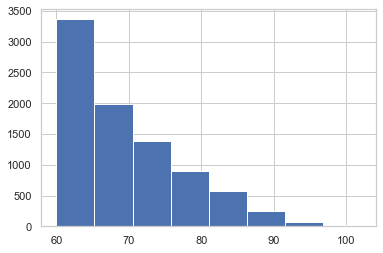

In [58]:
#age histogram
age_chart['age'].hist(bins=8)

In [60]:
#create bins/age group column
bins= [60,65,70,75,80,85,90,95,100]
labels = ['60-64','65-69','70-74','75-79','80-84','85-89','90-94','95-99']
age_chart['AgeGroup'] = pd.cut(age_chart['age'], bins=bins, labels=labels, right=False)
#age_chart.head(20)

<ipython-input-60-252f51c6bf8a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_chart['AgeGroup'] = pd.cut(age_chart['age'], bins=bins, labels=labels, right=False)


In [61]:
#number of patients in each age group, create data frame
age_chart_real = age_chart['AgeGroup'].value_counts().to_frame().reset_index()

In [62]:
#rename columns
age_chart_real.columns = ['Age Range', 'Enrollees']

In [63]:
age_chart_real

,Age Range,Enrollees
0,60-64,2731
1,65-69,2304
2,70-74,1477
3,75-79,978
4,80-84,552
5,85-89,330
6,90-94,126
7,95-99,34


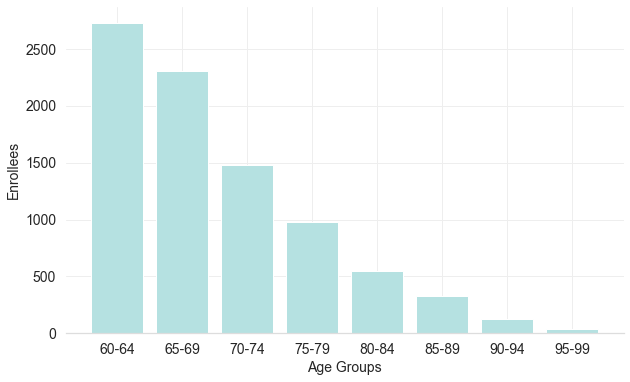

In [64]:
#age group bar chart
f, ax = plt.subplots(figsize=((10,6)))
ax.bar("Age Range", "Enrollees", data=age_chart_real, label="Total", color='#B5E1E1') #47709D #4179AB

#labels
ax.set_xlabel('Age Groups', fontsize = 14, fontfamily = 'Arial')
ax.set_xticklabels(age_chart_real['Age Range'], fontsize = 14, fontfamily = 'Arial')
ax.set_ylabel('Enrollees', fontsize=14, fontfamily = 'Arial')
ax.set_yticklabels([0, 500, 1000, 1500, 2000, 2500], fontsize = 14, fontfamily='Arial')

#styling
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(True, color='#EEEEEE');

In [65]:
#new data frame 'How did you first hear about the SMILE ON 60+ program?'
hear = smile_on[['CallerNum','SMILE ON 60+ Demographic Information - How did you first hear about the SMILE ON 60+ program?']]

In [66]:
#drop duplicate patients
hear = hear.drop_duplicates(['CallerNum'], keep='last')

In [67]:
#how they heard/number of patients 
marketing = hear['SMILE ON 60+ Demographic Information - How did you first hear about the SMILE ON 60+ program?'].value_counts().to_frame().reset_index()

In [68]:
#renmae columns
marketing.columns = ['Type', 'Number']

In [69]:
#sort values to get bar chart in right order
marketing = marketing.sort_values(by='Number', ascending=True)

In [70]:
marketing

,Type,Number
13,Tennessee Alliance for Legal Services,2
14,Habitat for Humanity Greater Memphis,2
11,Health Assist,11
12,Radio,11
10,SHIP Navigator,24
9,Dental Hotline,31
8,Newspaper,49
7,Flyer,135
6,TV,200
5,Senior Center,342


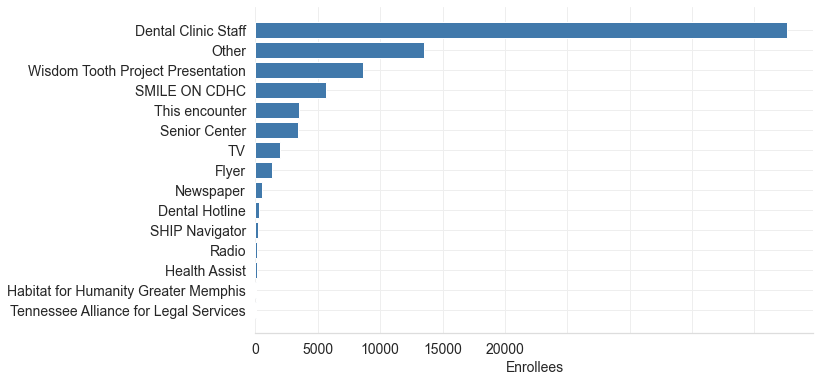

In [71]:
#create bar chart
f, ax = plt.subplots(figsize=((10,6)))
ax.barh("Type", "Number", data=marketing, label="Total", color='#4179AB') #47709D

#labels
ax.set_xlabel('Enrollees', fontsize = 14, fontfamily = 'Arial')
ax.set_xticklabels([0, 5000, 10000, 15000, 20000], fontsize = 14, fontfamily = 'Arial')
ax.set_ylabel('', fontsize=14)
ax.set_yticklabels(marketing['Type'], fontsize = 14, fontfamily='Arial')

#styling
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(True, color='#EEEEEE');